In [1]:
import os
import numpy as np
import time
import copy
import sys

import matplotlib
import matplotlib.pyplot as plt


ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import atomistic_tools.cp2k_stm_utilities as csu

In [110]:
path = "/home/kristjan/local_work/morbs_test/cnt120-L2-spin-pol/morbs_h1_dx0.2.npz"

In [111]:
path = "/home/kristjan/sshfs/daint_scratch/cp2k_pyrene_gnr/stm_output/stm_ch.npz"

In [112]:
npz_file_data = np.load(path)

In [113]:
npz_file_data

In [114]:
for key in npz_file_data:
    print(key)

data
heights
bias
x
y


In [116]:
npz_file_data['data'].shape

(2, 649, 306, 4)

In [88]:
a = np.ones((3, 3, 3))

In [104]:
c = np.array([1, 2, 3, 2])

In [105]:
(c == 2).sum()

2

In [108]:
np.concatenate(([10.0], c))

array([ 10.,   1.,   2.,   3.,   2.])

In [93]:
b = np.zeros((3, 3, 1))

In [96]:
np.concatenate((a, b), axis=2)

array([[[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  0.]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  0.]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  0.]]])

In [76]:
x_arr = npz_file_data['x_arr']
y_arr = npz_file_data['y_arr']
z_arr = npz_file_data['z_arr']
mol_bbox = npz_file_data['mol_bbox']
elim = npz_file_data['elim']
ref_energy = npz_file_data['ref_energy']
geom_label = npz_file_data['geom_label']

In [77]:
morb_grids = [npz_file_data['morb_grids_s1']]
morb_energies = [npz_file_data['morb_energies_s1']]
homo_inds = [npz_file_data['homo_s1']]

if 'morb_grids_s2' in npz_file_data:
    morb_grids.append(npz_file_data['morb_grids_s2'])
    morb_energies.append(npz_file_data['morb_energies_s2'])
    homo_inds.append(npz_file_data['homo_s2'])

In [67]:
morb_grids[0].shape

(5, 210, 68, 1)

In [80]:
z_arr

array([ 36.20174028])

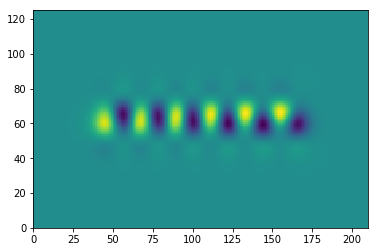

In [59]:
plt.pcolormesh(morb_grids[0][2, :, :, 0].T)
plt.show()

In [68]:
z_arr

array([ 36.20174028])

In [70]:
y_arr

array([ 14.8208651 ,  15.19639238,  15.57191965,  15.94744693,
        16.3229742 ,  16.69850148,  17.07402875,  17.44955603,
        17.8250833 ,  18.20061058,  18.57613785,  18.95166513,
        19.3271924 ,  19.70271968,  20.07824695,  20.45377423,
        20.8293015 ,  21.20482878,  21.58035606,  21.95588333,
        22.33141061,  22.70693788,  23.08246516,  23.45799243,
        23.83351971,  24.20904698,  24.58457426,  24.96010153,
        25.33562881,  25.71115608,  26.08668336,  26.46221063,
        26.83773791,  27.21326518,  27.58879246,  27.96431973,
        28.33984701,  28.71537428,  29.09090156,  29.46642883,
        29.84195611,  30.21748338,  30.59301066,  30.96853793,
        31.34406521,  31.71959248,  32.09511976,  32.47064703,
        32.84617431,  33.22170158,  33.59722886,  33.97275613,
        34.34828341,  34.72381068,  35.09933796,  35.47486523,
        35.85039251,  36.22591978,  36.60144706,  36.97697433,
        37.35250161,  37.72802888,  38.10355616,  38.47